In [13]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error

# King Ryiadh Dataset

In [14]:
df_raw = pd.read_excel("possible_datasets/KSMC_Hospital/ksmc_icu_registry_dataset.xlsx")

In [16]:
df1 = df_raw.copy()
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79000 entries, 0 to 78999
Data columns (total 20 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   Patient_ID                      79000 non-null  object        
 1   Age                             79000 non-null  int64         
 2   Gender                          79000 non-null  object        
 3   Nationality                     79000 non-null  object        
 4   Hospital_Name                   79000 non-null  object        
 5   ICU_Type                        79000 non-null  object        
 6   Admission_Date                  79000 non-null  datetime64[ns]
 7   Length_of_Stay_Days             79000 non-null  int64         
 8   Primary_Diagnosis_Group         79000 non-null  object        
 9   Severity_Score                  79000 non-null  int64         
 10  Comorbidities_Count             79000 non-null  int64         
 11  Ve

In [17]:
df1['Admission_Date'] = pd.to_datetime(df1['Admission_Date']).dt.date
df1.sort_values('Admission_Date', inplace=True)

def age_group(age):
    if age < 18:
        return '0-17'
    elif 18 <= age <= 45:
        return '18-45'
    elif 46 <= age <= 65:
        return '46-65'
    else:
        return '65+'


df1["Age"] = df1["Age"].apply(age_group)
df1.head()

,Patient_ID,Age,Gender,Nationality,Hospital_Name,ICU_Type,Admission_Date,Length_of_Stay_Days,Primary_Diagnosis_Group,Severity_Score,Comorbidities_Count,Ventilator_Used,Dialysis_Required,Number_of_Lab_Tests,Number_of_Radiology_Procedures,Total_Cost_SAR,Cost_Per_Day_SAR,Discharge_Status,Readmission_30days,Discharge_Date
43853,PT043854,0-17,Male,Saudi,King Fahad Medical City,Medical ICU,2018-01-01,10,Cancer,4,1,No,No,22,5,39102.404053,8637.479652,Recovered,No,2018-01-11 09:22:45
23694,PT023695,46-65,Female,Saudi,King Abdulaziz Medical City,Neonatal ICU,2018-01-01,7,Cancer,14,1,No,No,39,5,80309.285752,3451.470184,Deceased,No,2018-01-08 04:58:35
23817,PT023818,46-65,Male,Non-Saudi,King Fahad Medical City,Medical ICU,2018-01-01,4,Renal Failure,23,1,No,No,44,3,75101.339749,8869.632336,Transferred,No,2018-01-05 12:25:33
37370,PT037371,46-65,Female,Saudi,King Khalid University Hospital,Cardiac ICU,2018-01-01,3,Respiratory,19,5,No,No,23,5,51145.438612,5305.430523,Recovered,No,2018-01-04 13:23:06
30068,PT030069,65+,Male,Saudi,King Saud Medical City,Surgical ICU,2018-01-01,3,Neurological,6,2,No,No,19,1,68075.727509,2429.535975,Recovered,No,2018-01-04 17:46:26


In [18]:
df1.Admission_Date.min(), df1.Admission_Date.max()

(datetime.date(2018, 1, 1), datetime.date(2024, 3, 31))

In [19]:
dates = pd.date_range(
    start="2018-01-01",
    end="2024-03-31",
    freq="M"    # M = Month End
).date
dates = [d.strftime("%Y-%m") for d in dates]
len(dates)

C:\Users\Luca\AppData\Local\Temp\ipykernel_12592\43577845.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


75

In [20]:
df_pivot = df1.pivot_table(index=['Age', 'Gender'], aggfunc=list)
df_pivot = df_pivot.reset_index()
df_pivot = df_pivot[["Age", "Gender", "Admission_Date"]]

In [21]:
def count_admissions(admission_dates):
    admission_months = [a.strftime("%Y-%m") for a in admission_dates]
    count_admissions = []
    for date in dates:
        count_admissions.append(int(admission_months.count(date)))
    return count_admissions

admission_counts = df_pivot["Admission_Date"].apply(count_admissions)
df_pivot["Admission_Date"] = [dates for _ in range(len(df_pivot))]
df_pivot["Admission_Counts"] = admission_counts
df_pivot.to_csv("possible_datasets/KSMC_Hospital/data_preprocessed.csv", index=False)
df_pivot

,Age,Gender,Admission_Date,Admission_Counts
0,0-17,Female,"[2018-01, 2018-02, 2018-03, 2018-04, 2018-05, ...","[118, 99, 99, 90, 94, 127, 82, 110, 105, 112, ..."
1,0-17,Male,"[2018-01, 2018-02, 2018-03, 2018-04, 2018-05, ...","[88, 93, 112, 94, 109, 96, 110, 114, 94, 109, ..."
2,18-45,Female,"[2018-01, 2018-02, 2018-03, 2018-04, 2018-05, ...","[149, 154, 174, 151, 194, 164, 168, 182, 146, ..."
3,18-45,Male,"[2018-01, 2018-02, 2018-03, 2018-04, 2018-05, ...","[167, 153, 157, 161, 149, 167, 180, 171, 159, ..."
4,46-65,Female,"[2018-01, 2018-02, 2018-03, 2018-04, 2018-05, ...","[121, 114, 110, 134, 105, 119, 143, 124, 107, ..."
5,46-65,Male,"[2018-01, 2018-02, 2018-03, 2018-04, 2018-05, ...","[113, 121, 109, 117, 123, 127, 131, 107, 87, 1..."
6,65+,Female,"[2018-01, 2018-02, 2018-03, 2018-04, 2018-05, ...","[144, 137, 146, 128, 155, 111, 129, 130, 143, ..."
7,65+,Male,"[2018-01, 2018-02, 2018-03, 2018-04, 2018-05, ...","[137, 134, 170, 144, 132, 130, 145, 141, 141, ..."


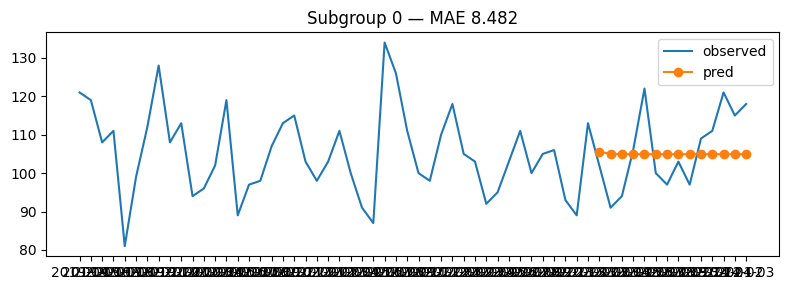

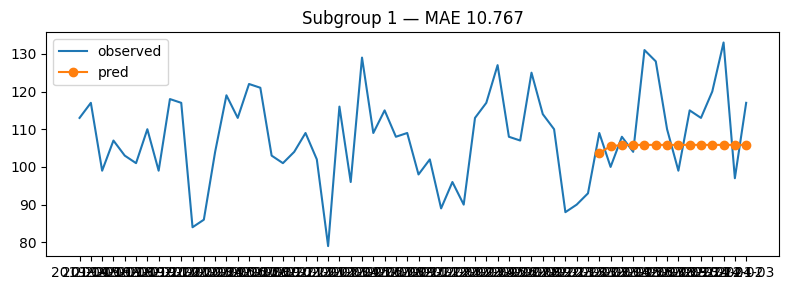

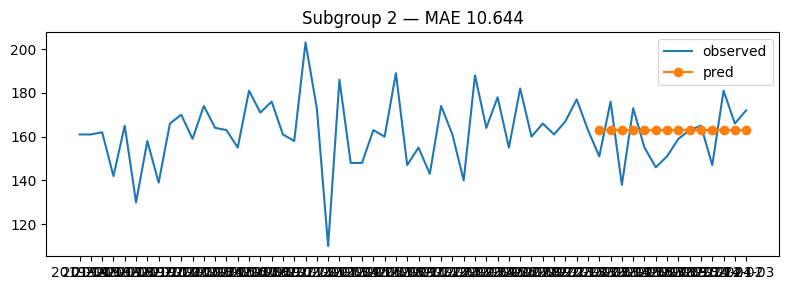

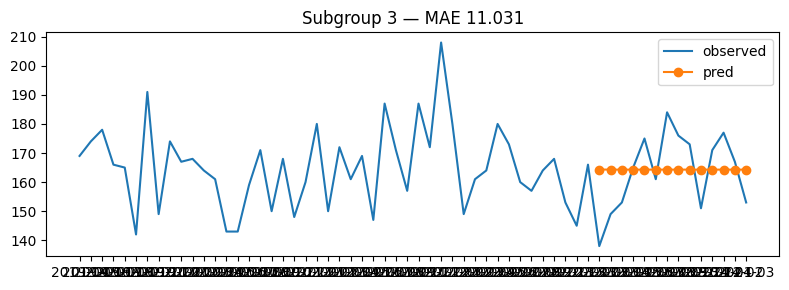

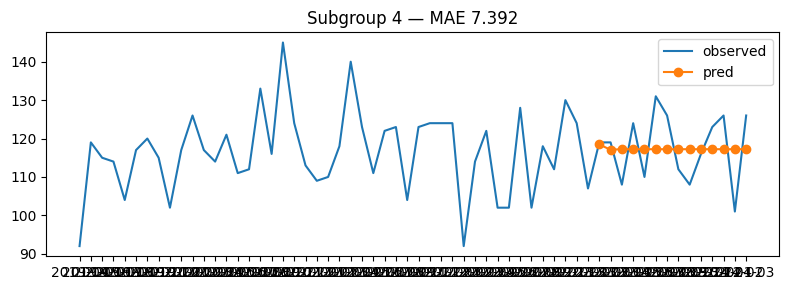

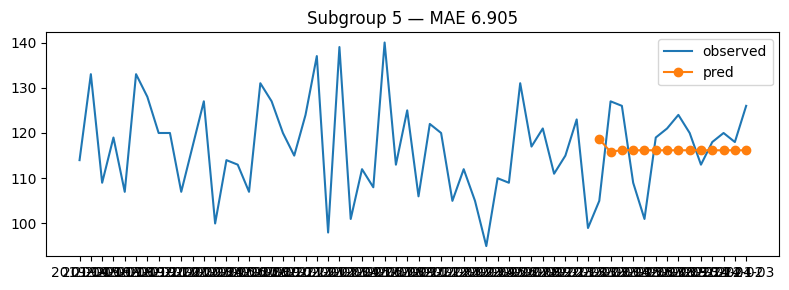

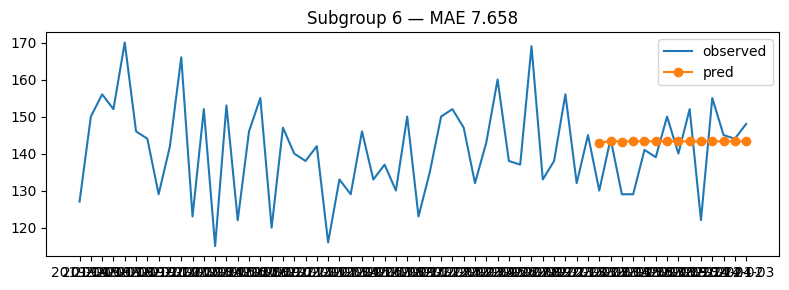

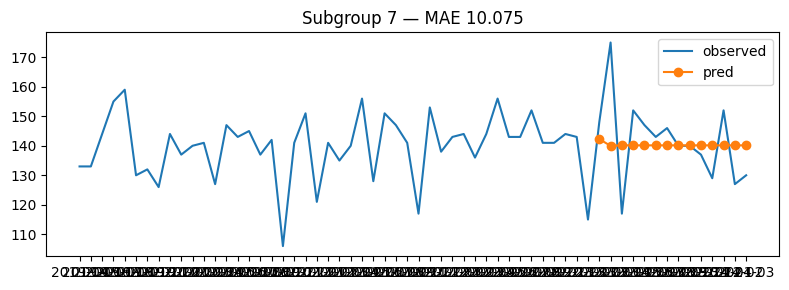


--- Fairness summary (MAE per subgroup) ---
0: MAE = 8.482
1: MAE = 10.767
2: MAE = 10.644
3: MAE = 11.031
4: MAE = 7.392
5: MAE = 6.905
6: MAE = 7.658
7: MAE = 10.075
MAE gap (max - min) across chosen subgroups = 4.126


In [9]:
# ---------- modeling loop: train/test split and SARIMAX ----------
results = {}
h = 14  # forecast horizon (days) for evaluation
for sg in df_pivot.index:
    series = df_pivot.iloc[sg,3].copy()
    # train/test split
    train = series[:-h]
    test  = series[-h:]

    # difference if strongly non-stationary - we'll try simple SARIMAX(1,1,1)
    try:
        model = SARIMAX(train, order=(1,1,1), seasonal_order=(0,0,0,0), enforce_stationarity=False, enforce_invertibility=False)
        fit = model.fit(disp=False, method='lbfgs', maxiter=200)
        pred = fit.get_forecast(steps=h).predicted_mean
    except Exception as e:
        print(f"[{sg}] SARIMAX failed ({e}), falling back to naive persistence forecast.")
        pred = pd.Series(train.iloc[-1], index=test.index)
    
    mae = mean_absolute_error(test, pred)
    results[sg] = dict(mae=float(mae), true=test, pred=pred)

    # quick plot
    plt.figure(figsize=(8,3))
    plt.plot(df_pivot.iloc[0, 2][-60:], series[-60:], label='observed')
    plt.plot(df_pivot.iloc[0, 2][-h:], pred, 'o-', label='pred')
    plt.title(f"Subgroup {sg} — MAE {mae:.3f}")
    plt.legend()
    plt.tight_layout()
    plt.show()

# ---------- fairness summary ----------
print("\n--- Fairness summary (MAE per subgroup) ---")
for sg,info in results.items():
    print(f"{sg}: MAE = {info['mae']:.3f}")

# simple gap metric: max - min MAE among modeled subgroups
maes = [info['mae'] for info in results.values()]
if len(maes) > 1:
    gap = max(maes) - min(maes)
    print(f"MAE gap (max - min) across chosen subgroups = {gap:.3f}")
else:
    print("Only one subgroup modeled — no gap to report.")

# Inequality in Education

In [72]:
df_edu = pd.read_csv("possible_datasets/Inequality in Education.csv")
df_edu = df_edu.dropna()
df_edu.drop(columns=["ISO3"], inplace=True)
df_edu["Inequality in Education (2010-2021)"] = [a for a in df_edu.iloc[:, 4:].values]
df_edu.drop(columns=df_edu.columns[4:-1], inplace=True)
df_edu

,Country,Human Development Groups,UNDP Developing Regions,HDI Rank (2021),Inequality in Education (2010-2021)
0,Afghanistan,Low,SA,180.0,"[42.809, 44.82338, 44.82338, 44.82338, 44.8233..."
2,Albania,High,ECA,67.0,"[11.9, 11.9, 11.9, 11.9, 11.9, 11.9, 11.9, 12...."
5,Argentina,Very High,LAC,47.0,"[6.91431, 6.8309, 6.43056, 6.51336, 6.19228, 6..."
6,Armenia,High,ECA,85.0,"[3.685, 3.685, 3.685, 3.685, 3.685, 3.685, 2.9..."
10,Azerbaijan,High,ECA,91.0,"[3.727167133, 3.73117071, 3.702155473, 3.51566..."
...,...,...,...,...,...
187,Venezuela,Medium,LAC,120.0,"[17.53291796, 13.35926304, 13.35926304, 13.359..."
188,Viet Nam,High,EAP,115.0,"[16.57815, 16.57815, 16.57815, 16.57815, 17.63..."
191,Yemen,Low,AS,183.0,"[48.09012, 48.09012, 48.09012, 46.13765, 46.13..."
193,Zambia,Medium,SSA,154.0,"[23.76, 23.76, 23.76, 23.76, 21.73491, 21.7349..."


In [73]:
df_edu.set_index("Human Development Groups").sort_index()

,Country,UNDP Developing Regions,HDI Rank (2021),Inequality in Education (2010-2021)
Human Development Groups,,,,
High,Paraguay,LAC,105.0,"[14.55382, 14.11541, 14.12982, 13.75303, 13.45..."
High,Egypt,AS,97.0,"[40.9, 40.9, 38.143, 38.143, 36.94291, 36.9429..."
High,Ecuador,LAC,95.0,"[17.4609, 16.38272, 16.42115, 15.45335, 14.180..."
High,Dominican Republic,LAC,80.0,"[20.18834, 19.58799, 18.99107, 19.03638, 18.99..."
High,Peru,LAC,84.0,"[17.49038, 17.17164, 16.37128, 16.22708, 16.08..."
...,...,...,...,...
Very High,Chile,LAC,42.0,"[13.36599543, 14.94046313, 14.94046313, 12.679..."
Very High,Qatar,AS,42.0,"[19.05350472, 19.88182141, 18.42700576, 14.118..."
Very High,Oman,AS,54.0,"[30.54286069, 30.54286069, 30.54286069, 30.542..."


# Countries COSGDD data

In [87]:
df_cosgdd = pd.read_csv("possible_datasets/COSGDD/Money_vs_Happiness_dataset.csv")
df_cosgdd.Year.value_counts().sort_index()

Year
2008     92
2010    103
2011    119
2012    118
2013    111
2014    113
2015    113
2016    112
2017    116
2018    116
2019    119
2020     95
2021     93
Name: count, dtype: int64

In [91]:
df_cosgdd = df_cosgdd.loc[df_cosgdd['Year'] != 2008]
for country in df_cosgdd['Country'].unique():
    if df_cosgdd[df_cosgdd['Country'] == country].Year.nunique() != 12:
        df_cosgdd = df_cosgdd[df_cosgdd['Country'] != country]
df_cosgdd.set_index(['Country', 'Year'])

Life Ladder  Log GDP per capita  Social support  \
Country   Year                                                    
Argentina 2010     6.441067           10.065660        0.926799   
          2011     6.775805           10.112436        0.889073   
          2012     6.468387           10.090750        0.901776   
          2013     6.582260           10.103327        0.909874   
          2014     6.671114           10.066885        0.917870   
...                     ...                 ...             ...   
Vietnam   2017     5.175279            9.110596             NaN   
          2018     5.295547            9.173263        0.831945   
          2019     5.467451            9.235229        0.847592   
          2020     5.462342            9.254416        0.764510   
          2021     5.540250            9.271268        0.799494   

                Healthy life expectancy at birth  \
Country   Year                                     
Argentina 2010                         66.300003   
          2011                         66.419998   
          2012                         66.540001   
          2013                         66.660004   
          2014                         66.779999   
...                                          ...   
Vietnam   2017                         65.099998   
          2018                         65.199997   
          2019                         65.300003   
          2020                         65.400002   
          2021                         65.500000   

                Freedom to make life choices  Generosity  \
Country   Year                                             
Argentina 2010                      0.730258   -0.131507   
          2011                      0.815802   -0.179832   
          2012                      0.747498   -0.153442   
          2013                      0.737250   -0.135954   
          2014                      0.745058   -0.169978   
...                                      ...         ...   
Vietnam   2017                           NaN         NaN   
          2018                      0.909260   -0.063384   
          2019                      0.952469   -0.148437   
          2020                      0.944707    0.063276   
          2021                      0.896800    0.104378   

                Perceptions of corruption  Positive affect  Negative affect  \
Country   Year                                                                
Argentina 2010                   0.854695         0.765480         0.210975   
          2011                   0.754646         0.768943         0.231855   
          2012                   0.816546         0.744064         0.272219   
          2013                   0.822900         0.766157         0.254205   
          2014                   0.854192         0.769468         0.237913   
...                                   ...              ...              ...   
Vietnam   2017                        NaN              NaN              NaN   
          2018                   0.808423         0.614404         0.191061   
          2019                   0.787889         0.657786         0.185610   
          2020                   0.791134         0.699165         0.286374   
          2021                   0.797788         0.650598         0.280437   

                     Regime type  ...  Food supply (kcal per capita per day)  \
Country   Year                    ...                                          
Argentina 2010  Flawed democracy  ...                              3077.9998   
          2011  Flawed democracy  ...                              3071.0002   
          2012  Flawed democracy  ...                              3100.9998   
          2013  Flawed democracy  ...                              3132.0000   
          2014  Flawed democracy  ...                              3170.9990   
...                          ...  ...                                    ...   
Vietnam   2017    

In [93]:
# time series data for various aspects over 12 years can be used, multiple different aspects can be investigated
# countries can be grouped by performance indices like democracy index
df_cosgdd.Country.nunique()

68

# Restaurant visitor

In [ ]:
# Justr take the data of the air restaurant visitor forecast dataset
# use daily data instead of hourly data
df_res = pd.read_csv("possible_datasets/recruit-restaurant-visitor-forecasting/air_visit_data.csv")# pd.read_csv("possible_datasets/recruit-restaurant-visitor-forecasting/air_reserve.csv")
df_date = pd.read_csv("possible_datasets/recruit-restaurant-visitor-forecasting/date_info.csv")
df_date = df_date.rename(columns={"calendar_date": "visit_date"})
df_res = pd.merge(df_res, df_date, on="visit_date", how="inner")
df_store = pd.read_csv("possible_datasets/recruit-restaurant-visitor-forecasting/air_store_info.csv")
df_rest = pd.merge(df_store, df_res, on="air_store_id", how = "inner")
df_rest.to_csv("possible_datasets/recruit-restaurant-visitor-forecasting/merged_restaurant_data.csv", index=False)

In [ ]:
# compare visitor numbers, different genres can be the subgroups
df_rest.set_index(['air_genre_name', 'air_store_id'])

air_area_name  \
air_genre_name air_store_id                                                  
Italian/French air_0f0cdeee6c9bf3d7           Hyōgo-ken Kōbe-shi Kumoidōri   
               air_0f0cdeee6c9bf3d7           Hyōgo-ken Kōbe-shi Kumoidōri   
               air_0f0cdeee6c9bf3d7           Hyōgo-ken Kōbe-shi Kumoidōri   
               air_0f0cdeee6c9bf3d7           Hyōgo-ken Kōbe-shi Kumoidōri   
               air_0f0cdeee6c9bf3d7           Hyōgo-ken Kōbe-shi Kumoidōri   
...                                                                    ...   
Karaoke/Party  air_c8fe396d6c46275d  Hokkaidō Sapporo-shi Minami 3 Jōnishi   
               air_c8fe396d6c46275d  Hokkaidō Sapporo-shi Minami 3 Jōnishi   
               air_c8fe396d6c46275d  Hokkaidō Sapporo-shi Minami 3 Jōnishi   
               air_c8fe396d6c46275d  Hokkaidō Sapporo-shi Minami 3 Jōnishi   
               air_c8fe396d6c46275d  Hokkaidō Sapporo-shi Minami 3 Jōnishi   

                                      latitude   longitude  visit_date  \
air_genre_name air_store_id                                              
Italian/French air_0f0cdeee6c9bf3d7  34.695124  135.197853  2016-07-01   
               air_0f0cdeee6c9bf3d7  34.695124  135.197853  2016-07-02   
               air_0f0cdeee6c9bf3d7  34.695124  135.197853  2016-07-03   
               air_0f0cdeee6c9bf3d7  34.695124  135.197853  2016-07-04   
               air_0f0cdeee6c9bf3d7  34.695124  135.197853  2016-07-05   
...                                        ...         ...         ...   
Karaoke/Party  air_c8fe396d6c46275d  43.055460  141.340956  2017-04-18   
               air_c8fe396d6c46275d  43.055460  141.340956  2017-04-19   
               air_c8fe396d6c46275d  43.055460  141.340956  2017-04-20   
               air_c8fe396d6c46275d  43.055460  141.340956  2017-04-21   
               air_c8fe396d6c46275d  43.055460  141.340956  2017-04-22   

                                     visitors day_of_week  holiday_flg  
air_genre_name air_store_id                                             
Italian/French air_0f0cdeee6c9bf3d7        18      Friday            0  
               air_0f0cdeee6c9bf3d7        37    Saturday            0  
               air_0f0cdeee6c9bf3d7        20      Sunday            0  
               air_0f0cdeee6c9bf3d7        16      Monday            0  
               air_0f0cdeee6c9bf3d7        15     Tuesday            0  
...                                       ...         ...          ...  
Karaoke/Party  air_c8fe396d6c46275d        25     Tuesday            0  
               air_c8fe396d6c46275d        12   Wednesday            0  
               air_c8fe396d6c46275d        11    Thursday            0  
               air_c8fe396d6c46275d        35      Friday            0  
               air_c8fe396d6c46275d         9    Saturday            0  

[252108 rows x 7 columns]

# Walmart

In [118]:
df_m5_eval = pd.read_csv("possible_datasets/m5-forecasting-accuracy/sales_train_evaluation.csv")
df_m5_val = pd.read_csv("possible_datasets/m5-forecasting-accuracy/sales_train_validation.csv")
df_calendar = pd.read_csv("possible_datasets/m5-forecasting-accuracy/calendar.csv")
df_sells_prices = pd.read_csv("possible_datasets/m5-forecasting-accuracy/sell_prices.csv")

For validation we have test data to check our predictions, for eval we haven't data so only use validation data

In [122]:
df_m5_val

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,1,0,1,1,2,2,2,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,FOODS_3_823_WI_3_validation,FOODS_3_823,FOODS_3,FOODS,WI_3,WI,0,0,2,2,...,2,0,0,0,0,0,1,0,0,1
30486,FOODS_3_824_WI_3_validation,FOODS_3_824,FOODS_3,FOODS,WI_3,WI,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
30487,FOODS_3_825_WI_3_validation,FOODS_3_825,FOODS_3,FOODS,WI_3,WI,0,6,0,2,...,2,1,0,2,0,1,0,0,1,0
30488,FOODS_3_826_WI_3_validation,FOODS_3_826,FOODS_3,FOODS,WI_3,WI,0,0,0,0,...,0,0,1,0,0,1,0,3,1,3


In [121]:
df_sells_prices

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26
3,CA_1,HOBBIES_1_001,11328,8.26
4,CA_1,HOBBIES_1_001,11329,8.26
...,...,...,...,...
6841116,WI_3,FOODS_3_827,11617,1.00
6841117,WI_3,FOODS_3_827,11618,1.00
6841118,WI_3,FOODS_3_827,11619,1.00
6841119,WI_3,FOODS_3_827,11620,1.00


In [ ]:
df_m5_val["sales"] = [a for a in df_m5_val.loc[:, "d_1":].values]
df_m5_val = df_m5_val.drop(columns=df_m5_val.loc[:, "d_1":"d_1913"].columns)
for c in df_calendar.columns:   #merge calendar 1913 values to df_m5_val 
    df_m5_val[c] = [df_calendar[c].values[:1913] for _ in range(len(df_m5_val))]
#predict sales by having multiple input features, group time series by state or category
df_m5_val.head()

,id,item_id,dept_id,cat_id,store_id,state_id,sales,date,wm_yr_wk,weekday,...,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[2011-01-29, 2011-01-30, 2011-01-31, 2011-02-0...","[11101, 11101, 11101, 11101, 11101, 11101, 111...","[Saturday, Sunday, Monday, Tuesday, Wednesday,...",...,"[1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[2011, 2011, 2011, 2011, 2011, 2011, 2011, 201...","[d_1, d_2, d_3, d_4, d_5, d_6, d_7, d_8, d_9, ...","[nan, nan, nan, nan, nan, nan, nan, nan, Super...","[nan, nan, nan, nan, nan, nan, nan, nan, Sport...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, ...","[0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, ...","[0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, ..."
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[2011-01-29, 2011-01-30, 2011-01-31, 2011-02-0...","[11101, 11101, 11101, 11101, 11101, 11101, 111...","[Saturday, Sunday, Monday, Tuesday, Wednesday,...",...,"[1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[2011, 2011, 2011, 2011, 2011, 2011, 2011, 201...","[d_1, d_2, d_3, d_4, d_5, d_6, d_7, d_8, d_9, ...","[nan, nan, nan, nan, nan, nan, nan, nan, Super...","[nan, nan, nan, nan, nan, nan, nan, nan, Sport...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, ...","[0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, ...","[0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, ..."
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[2011-01-29, 2011-01-30, 2011-01-31, 2011-02-0...","[11101, 11101, 11101, 11101, 11101, 11101, 111...","[Saturday, Sunday, Monday, Tuesday, Wednesday,...",...,"[1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[2011, 2011, 2011, 2011, 2011, 2011, 2011, 201...","[d_1, d_2, d_3, d_4, d_5, d_6, d_7, d_8, d_9, ...","[nan, nan, nan, nan, nan, nan, nan, nan, Super...","[nan, nan, nan, nan, nan, nan, nan, nan, Sport...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, ...","[0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, ...","[0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, ..."
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[2011-01-29, 2011-01-30, 2011-01-31, 2011-02-0...","[11101, 11101, 11101, 11101, 11101, 11101, 111...","[Saturday, Sunday, Monday, Tuesday, Wednesday,...",...,"[1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[2011, 2011, 2011, 2011, 2011, 2011, 2011, 201...","[d_1, d_2, d_3, d_4, d_5, d_6, d_7, d_8, d_9, ...","[nan, nan, nan, nan, nan, nan, nan, nan, Super...","[nan, nan, nan, nan, nan, nan, nan, nan, Sport...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, ...","[0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, ...","[0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, ..."
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[2011-01-29, 2011-01-30, 2011-01-31, 2011-02-0...","[11101, 11101, 11101, 11101, 11101, 11101, 111...","[Saturday, Sunday, Monday, Tuesday, Wednesday,...",...,"[1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[2011, 2011, 2011, 2011, 2011, 2011, 2011, 201...","[d_1, d_2, d_3, d_4, d_5, d_6, d_7, d_8, d_9, ...","[nan, nan, nan, nan, nan, nan, nan, nan, Super...","[nan, nan, nan, nan, nan, nan, nan, nan, Sport...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, 

# Favorita

In [177]:
df_hol = pd.read_csv("possible_datasets/store-sales-favorita/holidays_events.csv")
df_oil = pd.read_csv("possible_datasets/store-sales-favorita/oil.csv")
df_stores = pd.read_csv("possible_datasets/store-sales-favorita/stores.csv")
df_sample_sub = pd.read_csv("possible_datasets/store-sales-favorita/sample_submission.csv")
df_train = pd.read_csv("possible_datasets/store-sales-favorita/train.csv")
df_test = pd.read_csv("possible_datasets/store-sales-favorita/test.csv")
df_transactions = pd.read_csv("possible_datasets/store-sales-favorita/transactions.csv")

In [ ]:
df_train.drop(columns="id", inplace=True)
df_hol = df_hol.pivot_table(index=["date"], aggfunc=list)

def merge_dataframes(df):
    df = pd.merge(df, df_hol, on="date", how="left", validate = "many_to_one")
    df = pd.merge(df, df_oil, on="date", how="left", validate = "many_to_one")
    df = pd.merge(df, df_stores, on="store_nbr", how="left", validate="many_to_one")
    df = pd.merge(df, df_transactions, on=["store_nbr", "date"], how="left", validate="many_to_one")
    return df

df_train = merge_dataframes(df_train)
df_test = merge_dataframes(df_test)
df_train = df_train.pivot_table(index=['store_nbr'], aggfunc=list).head()

,city,cluster,date,dcoilwtico,description,family,locale,locale_name,onpromotion,sales,state,transactions,transferred,type_x,type_y
store_nbr,,,,,,,,,,,,,,,
1,"[Quito, Quito, Quito, Quito, Quito, Quito, Qui...","[13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 1...","[2013-01-01, 2013-01-01, 2013-01-01, 2013-01-0...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[[Primer dia del ano], [Primer dia del ano], [...","[AUTOMOTIVE, BABY CARE, BEAUTY, BEVERAGES, BOO...","[[National], [National], [National], [National...","[[Ecuador], [Ecuador], [Ecuador], [Ecuador], [...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[Pichincha, Pichincha, Pichincha, Pichincha, P...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[[False], [False], [False], [False], [False], ...","[[Holiday], [Holiday], [Holiday], [Holiday], [...","[D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, ..."
2,"[Quito, Quito, Quito, Quito, Quito, Quito, Qui...","[13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 1...","[2013-01-01, 2013-01-01, 2013-01-01, 2013-01-0...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[[Primer dia del ano], [Primer dia del ano], [...","[AUTOMOTIVE, BABY CARE, BEAUTY, BEVERAGES, BOO...","[[National], [National], [National], [National...","[[Ecuador], [Ecuador], [Ecuador], [Ecuador], [...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[Pichincha, Pichincha, Pichincha, Pichincha, P...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[[False], [False], [False], [False], [False], ...","[[Holiday], [Holiday], [Holiday], [Holiday], [...","[D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, ..."
3,"[Quito, Quito, Quito, Quito, Quito, Quito, Qui...","[8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, ...","[2013-01-01, 2013-01-01, 2013-01-01, 2013-01-0...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[[Primer dia del ano], [Primer dia del ano], [...","[AUTOMOTIVE, BABY CARE, BEAUTY, BEVERAGES, BOO...","[[National], [National], [National], [National...","[[Ecuador], [Ecuador], [Ecuador], [Ecuador], [...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[Pichincha, Pichincha, Pichincha, Pichincha, P...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[[False], [False], [False], [False], [False], ...","[[Holiday], [Holiday], [Holiday], [Holiday], [...","[D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, ..."
4,"[Quito, Quito, Quito, Quito, Quito, Quito, Qui...","[9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, ...","[2013-01-01, 2013-01-01, 2013-01-01, 2013-01-0...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[[Primer dia del ano], [Primer dia del ano], [...","[AUTOMOTIVE, BABY CARE, BEAUTY, BEVERAGES, BOO...","[[National], [National], [National], [National...","[[Ecuador], [Ecuador], [Ecuador], [Ecuador], [...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[Pichincha, Pichincha, Pichincha, Pichincha, P...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[[False], [False], [False], [False], [False], ...","[[Holiday], [Holiday], [Holiday], [Holiday], [...","[D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, ..."
5,"[Santo Domingo, Santo Domingo, Santo Domingo, ...","[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, ...","[2013-01-01, 2013-01-01, 2013-01-01, 2013-01-0...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[[Primer dia del ano], [Primer dia del ano], [...","[AUTOMOTIVE, BABY CARE, BEAUTY, BEVERAGES, BOO...","[[National], [National], [National], [National...","[[Ecuador], [Ecuador], [Ecuador], [Ecuador], [...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[Santo Domingo de los Tsachilas, Santo Domingo...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[[False], [False], [False], [False], [False], ...","[[Holiday], [Holiday], [Holiday], [Ho

# Exchange rate

In [ ]:
df_exchange =pd.read_csv("possible_datasets/exchange_rate.csv")
# if column renaming is correct was checked with https://www.ofx.com/en-au/forex-news/historical-exchange-rates/yearly-average-rates/
df_exchange.columns = ["date", "Australia", "Great Britain", "Canada", "Switzerland", "China", "Japan", "New Zealand", "Singapore"] #add country names according to description https://arxiv.org/pdf/1703.07015
# compare prediction fairness between different countries, maybe group countries according to GDP or something similar
df_exchange.T

,0,1,2,3,4,5,6,7,8,9,...,7578,7579,7580,7581,7582,7583,7584,7585,7586,7587
date,1990/1/1 0:00,1990/1/2 0:00,1990/1/3 0:00,1990/1/4 0:00,1990/1/5 0:00,1990/1/6 0:00,1990/1/7 0:00,1990/1/8 0:00,1990/1/9 0:00,1990/1/10 0:00,...,2010/10/1 0:00,2010/10/2 0:00,2010/10/3 0:00,2010/10/4 0:00,2010/10/5 0:00,2010/10/6 0:00,2010/10/7 0:00,2010/10/8 0:00,2010/10/9 0:00,2010/10/10 0:00
Australia,0.7855,0.7818,0.7867,0.786,0.7849,0.7866,0.7886,0.791,0.7939,0.7894,...,0.717618,0.719114,0.719114,0.719735,0.718701,0.718494,0.721839,0.723197,0.720825,0.720825
Great Britain,1.611,1.61,1.6293,1.637,1.653,1.6537,1.662,1.6568,1.6695,1.657,...,1.22519,1.2278,1.2278,1.228501,1.226001,1.222195,1.223459,1.234111,1.233905,1.233905
Canada,0.861698,0.861104,0.86103,0.862069,0.861995,0.86103,0.862887,0.864304,0.86423,0.858369,...,0.739235,0.738089,0.738089,0.740384,0.737776,0.737485,0.741155,0.745184,0.744131,0.744131
Switzerland,0.634196,0.633513,0.648508,0.650618,0.656254,0.654879,0.661157,0.659631,0.66912,0.659413,...,0.9738,0.973189,0.973189,0.973047,0.972479,0.969974,0.977297,0.984446,0.980344,0.980344
China,0.211242,0.211242,0.211242,0.211242,0.211242,0.211242,0.211242,0.211242,0.211242,0.211242,...,0.143962,0.143962,0.143962,0.143972,0.143833,0.143697,0.143763,0.143997,0.143993,0.143993
Japan,0.006838,0.006863,0.006975,0.006953,0.00694,0.006887,0.006885,0.006878,0.006878,0.006874,...,0.00853,0.008527,0.008527,0.008537,0.00851,0.0085,0.008595,0.008562,0.008555,0.008555
New Zealand,0.525486,0.523972,0.526316,0.523834,0.527426,0.526177,0.527565,0.527565,0.528123,0.528123,...,0.691009,0.691133,0.691133,0.690978,0.690164,0.688565,0.690288,0.691419,0.690942,0.690942
Singapore,0.593,0.594,0.5973,0.597,0.5985,0.604,0.607,0.6084,0.6115,0.609,...,0.687191,0.687687,0.687687,0.690846,0.688753,0.690846,0.695701,0.695943,0.692689,0.692689


# Influenca Illness

In [105]:
df_ill = pd.read_csv("possible_datasets/national_illness.csv")
# prediction task e.g. for subgroups age 0-4 and age 5-24
df_ill.T

,0,1,2,3,4,5,6,7,8,9,...,956,957,958,959,960,961,962,963,964,965
date,2002-01-01 00:00:00,2002-01-08 00:00:00,2002-01-15 00:00:00,2002-01-22 00:00:00,2002-01-29 00:00:00,2002-02-05 00:00:00,2002-02-12 00:00:00,2002-02-19 00:00:00,2002-02-26 00:00:00,2002-03-05 00:00:00,...,2020-04-28 00:00:00,2020-05-05 00:00:00,2020-05-12 00:00:00,2020-05-19 00:00:00,2020-05-26 00:00:00,2020-06-02 00:00:00,2020-06-09 00:00:00,2020-06-16 00:00:00,2020-06-23 00:00:00,2020-06-30 00:00:00
% WEIGHTED ILI,1.22262,1.33344,1.31929,1.49484,1.47195,1.58094,1.49426,1.40569,1.6141,1.45967,...,1.10043,1.17828,1.02473,0.990461,0.862614,0.839059,0.895958,0.910926,0.946945,0.963716
%UNWEIGHTED ILI,1.16668,1.2165,1.13057,1.25246,1.30237,1.40551,1.38437,1.32563,1.43475,1.25433,...,1.1221,1.08335,0.977093,0.909742,0.861322,0.846722,0.908885,0.941625,0.972185,1.01376
AGE 0-4,582,683,642,728,823,887,851,802,834,857,...,2558,2632,2554,2317,2534,2756,3203,3478,3734,3955
AGE 5-24,805,872,878,1045,1189,1272,1173,1166,978,1117,...,3937,3997,3726,3143,3525,3528,3778,3796,3818,3843
ILITOTAL,2060,2267,2176,2599,2907,3225,3097,2967,2709,3049,...,16877,16033,14054,12567,13244,12913,13979,14389,14999,15307
NUM. OF PROVIDERS,754,785,831,863,909,930,923,922,918,937,...,3344,3310,3260,3261,3271,3258,3254,3177,3066,3027
OT,176569,186355,192469,207512,223208,229454,223712,223818,188814,243078,...,1504061,1479946,1438348,1381381,1537636,1525058,1538038,1528103,1542813,1509928
